In [1]:
#from spektral.datasets import citation
import spektral
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from spektral.layers import GraphConv
from spektral import utils

from keras.models import Model
from keras.layers import Input, Dropout

Using TensorFlow backend.


### Source:
https://danielegrattarola.github.io/spektral/getting-started/

### Some test

In [2]:
data = spektral.datasets.citation.load_data('cora')
A, X, y_train, y_val, y_test, train_mask, val_mask, test_mask = data

N = A.shape[0]
F = X.shape[-1]
n_classes = y_train.shape[-1]

Loading cora dataset
Pre-processing node features


In [3]:
A.shape, X.shape, y_val.shape, y_test.shape, train_mask.shape, val_mask.shape, test_mask.shape

((2708, 2708), (2708, 1433), (2708, 7), (2708, 7), (2708,), (2708,), (2708,))

In [4]:
# Model definition
X_in = Input(shape=(F, ))  # Input layer for X
A_in = Input((N, ), sparse=True)  # Input layer for A

graph_conv_1 = GraphConv(16, activation='relu')([X_in, A_in])
dropout = Dropout(0.5)(graph_conv_1)
graph_conv_2 = GraphConv(n_classes, activation='softmax')([dropout, A_in])

# Build model
model = Model(inputs=[X_in, A_in], outputs=graph_conv_2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
A = utils.localpooling_filter(A)

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1433)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2708)         0                                            
__________________________________________________________________________________________________
graph_conv_1 (GraphConv)        (None, 16)           22944       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 16)           0           graph_conv_1[0][0]               
__________

In [7]:
# Train model
validation_data = ([X, A], y_val, val_mask)
model.fit([X, A],
          y_train,
          sample_weight=train_mask,
          epochs=100,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False)  # Shuffling data means shuffling the whole graph

Instructions for updating:
Use tf.cast instead.
Train on 2708 samples, validate on 2708 samples
Epoch 1/100
2708/2708 [==============================] - 1s 437us/step - loss: 1.9461 - weighted_acc: 0.1929 - val_loss: 1.9457 - val_weighted_acc: 0.1260
Epoch 2/100
2708/2708 [==============================] - 0s 13us/step - loss: 1.9453 - weighted_acc: 0.2429 - val_loss: 1.9451 - val_weighted_acc: 0.1540
Epoch 3/100
2708/2708 [==============================] - 0s 12us/step - loss: 1.9444 - weighted_acc: 0.2714 - val_loss: 1.9445 - val_weighted_acc: 0.2100
Epoch 4/100
2708/2708 [==============================] - 0s 13us/step - loss: 1.9437 - weighted_acc: 0.2857 - val_loss: 1.9440 - val_weighted_acc: 0.2740
Epoch 5/100
2708/2708 [==============================] - 0s 13us/step - loss: 1.9430 - weighted_acc: 0.3429 - val_loss: 1.9435 - val_weighted_acc: 0.2900
Epoch 6/100
2708/2708 [==============================] - 0s 13us/step - loss: 1.9415 - weighted_acc: 0.3786 - val_loss: 1.9431 - val_

Epoch 52/100
2708/2708 [==============================] - 0s 13us/step - loss: 1.8801 - weighted_acc: 0.7571 - val_loss: 1.9118 - val_weighted_acc: 0.5900
Epoch 53/100
2708/2708 [==============================] - 0s 19us/step - loss: 1.8767 - weighted_acc: 0.7857 - val_loss: 1.9109 - val_weighted_acc: 0.5900
Epoch 54/100
2708/2708 [==============================] - 0s 22us/step - loss: 1.8731 - weighted_acc: 0.7857 - val_loss: 1.9100 - val_weighted_acc: 0.5980
Epoch 55/100
2708/2708 [==============================] - 0s 23us/step - loss: 1.8732 - weighted_acc: 0.7714 - val_loss: 1.9092 - val_weighted_acc: 0.5980
Epoch 56/100
2708/2708 [==============================] - 0s 19us/step - loss: 1.8696 - weighted_acc: 0.7643 - val_loss: 1.9083 - val_weighted_acc: 0.6000
Epoch 57/100
2708/2708 [==============================] - 0s 17us/step - loss: 1.8719 - weighted_acc: 0.7714 - val_loss: 1.9074 - val_weighted_acc: 0.6040
Epoch 58/100
2708/2708 [==============================] - 0s 15us/step

In [8]:
# Evaluate model
eval_results = model.evaluate([X, A],
                              y_test,
                              sample_weight=test_mask,
                              batch_size=N)
print('Done.\n'
      'Test loss: {}\n'
      'Test accuracy: {}'.format(*eval_results))


2708/2708 [==============================] - 0s 5us/step
Done.
Test loss: 1.8558011054992676
Test accuracy: 0.6709999442100525


### Data loader:

https://github.com/danielegrattarola/spektral/blob/master/spektral/datasets/qm9.py

https://github.com/danielegrattarola/spektral/blob/master/examples/regression_molecules.py

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from spektral.datasets import qm9
from spektral.layers import EdgeConditionedConv, GlobalAttentionPool
from spektral.utils import label_to_one_hot

In [7]:
adj, nf, ef, y = qm9.load_data(return_type='numpy',
                               nf_keys='atomic_num',
                               ef_keys='type',
                               self_loops=True)

Loading QM9 dataset.
Reading SDF


100%|██████████| 133885/133885 [00:29<00:00, 4502.93it/s]


In [8]:
y_array = y[['cv']].values # Heat capacity at 298.15K
#y_array = y.iloc[:, 1:].values
y_array

array([[ 6.469],
       [ 6.316],
       [ 6.002],
       ...,
       [23.972],
       [24.796],
       [23.434]])

In [9]:
# Preprocessing
uniq_nf = np.unique(nf)
nf = label_to_one_hot(nf, uniq_nf)
uniq_ef = np.unique(ef)
ef = label_to_one_hot(ef, uniq_ef)
y_array_scaled = StandardScaler().fit_transform(y_array).reshape(-1, y_array.shape[-1])

In [10]:
# Train/test split
adj_train, adj_test, \
nf_train, nf_test,   \
ef_train, ef_test,   \
y_train, y_test = train_test_split(adj, nf, ef, y_array_scaled, test_size=0.1)

In [11]:
# Parameters
N = nf.shape[-2]          # Number of nodes in the graphs
F = nf.shape[-1]          # Node features dimensionality
S = ef.shape[-1]          # Edge features dimensionality
n_out = y_array.shape[-1]       # Dimensionality of the target
learning_rate = 1e-3      # Learning rate for SGD
epochs = 25               # Number of training epochs
batch_size = 64           # Batch size
es_patience = 5           # Patience fot early stopping

In [12]:
# Model definition
nf_in = Input(shape=(N, F))
adj_in = Input(shape=(N, N))
ef_in = Input(shape=(N, N, S))

gc1 = EdgeConditionedConv(32, activation='relu')([nf_in, adj_in, ef_in])
gc2 = EdgeConditionedConv(64, activation='relu')([gc1, adj_in, ef_in])
pool = GlobalAttentionPool(128)(gc2)
dense1 = Dense(128, activation='relu')(pool)

output = Dense(n_out)(dense1)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# Build model
model = Model(inputs=[nf_in, adj_in, ef_in], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 29, 6)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 29, 29)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 29, 29, 4)    0                                            
__________________________________________________________________________________________________
edge_conditioned_conv_1 (EdgeCo (None, 29, 32)       992         input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [14]:
# Callbacks
es_callback = EarlyStopping(monitor='val_loss', patience=es_patience)

In [15]:
nf_train.shape, adj_train.shape, ef_train.shape, y_train.shape

((120496, 29, 6), (120496, 29, 29), (120496, 29, 29, 4), (120496, 1))

In [16]:
# Train model
model.fit([nf_train, adj_train, ef_train],
          y_train,
          batch_size=batch_size,
          validation_split=0.1,
          epochs=epochs,
          callbacks=[es_callback])

Instructions for updating:
Use tf.cast instead.
Train on 108446 samples, validate on 12050 samples
Epoch 1/25
108446/108446 [==============================] - 110s 1ms/step - loss: 0.0616 - val_loss: 0.0425
Epoch 2/25
108446/108446 [==============================] - 108s 998us/step - loss: 0.0350 - val_loss: 0.0320
Epoch 3/25
108446/108446 [==============================] - 108s 999us/step - loss: 0.0317 - val_loss: 0.0265
Epoch 4/25
108446/108446 [==============================] - 108s 999us/step - loss: 0.0297 - val_loss: 0.0273
Epoch 5/25
108446/108446 [==============================] - 108s 998us/step - loss: 0.0273 - val_loss: 0.0224
Epoch 6/25
108446/108446 [==============================] - 108s 1000us/step - loss: 0.0256 - val_loss: 0.0304
Epoch 7/25
108446/108446 [==============================] - 108s 1000us/step - loss: 0.0246 - val_loss: 0.0246
Epoch 8/25
108446/108446 [==============================] - 108s 1000us/step - loss: 0.0228 - val_loss: 0.0249
Epoch 9/25
108446/10

In [17]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([nf_test, adj_test, ef_test],
                              y_test,
                              batch_size=batch_size)
print('Done.\n'
      'Test loss: {}'.format(eval_results))

Evaluating model.
13389/13389 [==============================] - 7s 501us/step
Done.
Test loss: 0.01427250599306511


Text(0, 0.5, 'Actual')

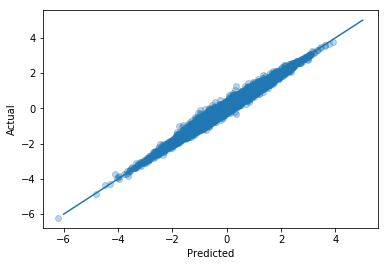

In [18]:
# Plot predictions
preds = model.predict([nf_test, adj_test, ef_test])

plt.figure()
plt.scatter(preds, y_test, alpha=0.3)
plt.plot(range(-6, 6), range(-6, 6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig('pred_v_true.png')

In [30]:
np.sqrt( np.sum( (preds - y_test)**2 ) / preds.shape[0] )

0.11946759377970118